<font size="5.5"><u><i>Make Injections</i></u></font>

<font size="4">Script to make injections: Multiple waveforms to noise strain data.</font>
<br/>
<font size="4">Author: Manuel David Morales</font>

## 1. Library imports

In [1]:
# Data analysis
import numpy as np 
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Files/folders management
import os, glob, sys, re

# To read csv files
import csv

# Garbage collector
import gc

# Object serialization
import pickle

# Toolbox functions
from Toolbox import PSD, SNR, SNR_PyCBC

## 2. Input parameters

In [2]:
# Interferometer for noise data
# ------------------------------------------------------------
detector = "H1"   # Options: "L1", "H1", "V1"
# ------------------------------------------------------------

# Class of waveforms to be injected
# ------------------------------------------------------------
waveform_class = "2"   # Options: "1", "2", "3"
# ------------------------------------------------------------

# Time between injections (in seconds)
# ------------------------------------------------------------
dt_inj = 8   # Options: 8, 12, 16, 32, 64
# ------------------------------------------------------------

# Jitter_lim: This value defines a fluctuation range, in which each
# injection will be located on a random sample in the interval
# [inj_time - jitter_lim, inj_time + jitter_lim] (in seconds)
# ------------------------------------------------------------
jitter_lim = 0.01   # Options: 0.3, 0.1, 0.0, 1.2, etc.
# ------------------------------------------------------------

# Time segment for SNR calculation around injection (in seconds)
# ----------------------------------------------------------------
t_segment = 4   #  [ t_inj-t_segment/2 , t_inj+t_segment/2 ] 
# ----------------------------------------------------------------

# ------> Input parameters for brief exploration and debugging

# Work on a reduced noise segment?
# ----------------------------------------------------------------
reduce_segment = 1   #  1: yes | 0: no
# ----------------------------------------------------------------

# Length of the reduced noise segment (in seconds)
# ----------------------------------------------------------------
reduced_time_n = 120.0                      
# ----------------------------------------------------------------

## 3. Read noise files

In [3]:
# ------> Specify folder locations

rawdata_dir = '/home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Codes/'

# ------> Initialize lists

time_noise = []
strain_noise = []
F_noi = []

# ------> Scan noise files

os.chdir(rawdata_dir)

for file in glob.glob("strain_noise_" + detector + "*"):
    F_noi.append(file)

In [4]:
# ------> Load noise data 

result = re.search( detector + "_", F_noi[0])
ind_ini_n = result.span()[1]
result = re.search( ".txt", F_noi[0])
ind_end_n = result.span()[0]

print("Available noise segments (in GPS start time)")
for j in range(len(F_noi)):
    print("GPS =", F_noi[j][ind_ini_n:ind_end_n], "  |  Input option :", j)
print("")

nfile_i = input("======> Enter your option:")
nfile_i = int(nfile_i)
print("")

print("***** READING FILE", F_noi[nfile_i], " *****")

with open(F_noi[nfile_i]) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Data columns: {", ".join(row)}')
            line_count += 1
        else:
            time_noise.append(row[0])
            strain_noise.append(row[1])
            #print(f'\t{row[0]} works in the {row[1]}.')
            line_count += 1
    print(f'Processed {line_count} lines')

Available noise segments (in GPS start time)
GPS = 1256783872   |  Input option : 0
GPS = 1257050112   |  Input option : 1



======> Enter your option: 1



***** READING FILE strain_noise_H1_1257050112.txt  *****
Data columns: time, strain
Processed 16777217 lines


In [5]:
# ------> Convert lists to numpy arrays, clear memory from lists

time_n = np.array(time_noise, dtype='float64')
del(time_noise)
gc.collect()

strain_n = np.array(strain_noise, dtype='float64')
del(strain_noise)
gc.collect()

0

## 4. Injections preparation

In [6]:
# Compute sampling time

ts = time_n[1] - time_n[0]

# -------> JUST FOR DEBUGGING THE IMPLEMENTATION
#          Select a portion of the noise strain data

if reduce_segment:
    
    reduced_length = int(reduced_time_n/ts)     # Reduced noise arrays' length (in sample units)
    
    time_n = np.delete(time_n,np.arange(reduced_length, len(time_n), 1, dtype=int))
    strain_n = np.delete(strain_n,np.arange(reduced_length, len(strain_n), 1, dtype=int))
    
    #print("time_n vector:", time_n)
    print("**** length of time_n (in seconds):", len(time_n)*ts)
    print("**** length of time_n (in sample units):", len(time_n))
    print("**** length of strain_n (in sample units):", len(strain_n))

**** length of time_n (in seconds): 120.0
**** length of time_n (in sample units): 491520
**** length of strain_n (in sample units): 491520


In [7]:
# ------> Backup original strain arrays
strain_n_new = np.copy(strain_n) # ---> Deep copy in numpy, to unbind arrays

# ------> Print useful input information

# Sampling frequency
fs =1/ts
print("Sampling frequency (in Hz): ", fs)

# Index of the strain noise sample (point) in which the first injection will be performed
N_lapse = int(dt_inj/(1./fs))
print("First noise sample to be injected with a waveform (without jitter): ", N_lapse)
print("Its correspondent strain value:", strain_n_new[N_lapse])

# Number of injections to be performed in the strain data
N_inj = int(len(strain_n_new) / N_lapse) - 1 
# Remark: -1 value in N_inj is just to avoid incomplete injection at the right edge.  
print("Number of injections to be performed: ", N_inj)

Sampling frequency (in Hz):  4096.0
First noise sample to be injected with a waveform (without jitter):  32768
Its correspondent strain value: -1.4795957120286136e-20
Number of injections to be performed:  14


In [8]:
# ------> Load waveforms dictionaries

# Waveforms strain
with open('../Waveforms_mod/Phen/waveforms.pkl', 'rb') as fp:
    waveforms = pickle.load(fp)
    print('waveforms dictionary loaded successfully')

# Waveforms log data
with open('../Waveforms_mod/Phen/waveforms_log.pkl', 'rb') as fp:
    waveforms_log = pickle.load(fp)
    print('waveforms_log dictionary loaded successfully')
    
# Remark: How to access waveforms and log data
# waveforms["class c"][n]  ---> to extract n-th waveform of class c
# waveforms_log["class c"][n]  ---> to extract log data of n-th waveform of class c

waveforms dictionary loaded successfully
waveforms_log dictionary loaded successfully


In [9]:
# Checks
print(len(waveforms["class 1"]))
print(len(waveforms["class 2"]))

200
200


In [10]:
# ------> Select random waveforms for injections

# Predictable random numbers
np.random.seed(23)

# 42 for noise gps_start 1257050112
# 23 for noise gps_start 1256783872

# Select N_inj random injections for the selected class
inj_ind = np.random.choice(len(waveforms["class " + waveform_class]), N_inj)

# Print indexes of selected waveform for injection
print("Choosen waveforms: ", inj_ind)

Choosen waveforms:  [ 83  40 182  31  91  39  90 153 179   6 123 173  12  49]


## 5. Injections application

In [11]:
doplots_snr = 0 # Do plots in SNR calculation (checks)

# ------> Create array to locate injections by indexes

locate_inj = np.arange(1,N_inj+1)
locate_inj = N_lapse*locate_inj
#print(locate_inj[-1] + N_lapse)
#print(len(strain_n_new))

# ------> Define length of local noise segment for SNR calculation

epsilon = int(int(t_segment/ts)*0.5)
#print("Epsilon = ", epsilon)

# ------> Initialize list for log file

log_data = []

# ------> Make injections

# FIRST LOOP, j index: injection count variable
# -----------------------------------------------

for j in range(N_inj): # Apply N_inj injections
#for j in range(10): # Apply only a few injections
        
    print("Injection No.", j)
    print("----------------------")
    
    # ------> Load random waveform indexed by inj_ind array
    
    strain_wf = np.transpose(waveforms["class " + waveform_class][inj_ind[j]])[1]
    
    # ------> Load waveform log data
    
    slope = waveforms_log["class " + waveform_class][inj_ind[j]][0]
    f0 = waveforms_log["class " + waveform_class][inj_ind[j]][1]
    f1 = waveforms_log["class " + waveform_class][inj_ind[j]][2]
    wf_duration = waveforms_log["class " + waveform_class][inj_ind[j]][3]
    
    slope = float(slope)
    f0 = float(f0); f1 = float(f1)
    wf_duration = float(wf_duration)
    
    # ------> Injection location without jitter
    
    ind_noise = locate_inj[j] # Locate first point of the injection
    # print("Injection first point in the strain noise data (without jitter):", ind_noise)
    
    time_inj = (1./fs)*ind_noise
    print("Time injection, without jitter (in seconds):", time_inj)
    
    # ------> Jitter variable procedure
    
    # Define the jitter range in terms of sample units
    njitter_range_min = ind_noise + int(-jitter_lim/(1./fs))
    njitter_range_max = ind_noise + int(jitter_lim/(1./fs))
    njitter_range = np.arange(njitter_range_min, njitter_range_max + 1, 1, dtype=int)

    # Compute actual location of the injection in sample units
    njitter = np.random.choice(njitter_range, 1)[0]
    
    # Some checks
    #print("Jitter variable range (in sample units):", njitter_range)
    #print("Modified injection location (in sample units):", njitter)
    current_jitter = (njitter-ind_noise)*(1/fs)
    print("Current jitter (in seconds):", current_jitter)
    
    time_inj_jit = njitter*(1/fs)
    print("Time injection, with jitter (in seconds):", time_inj_jit)

    # ------> Update index injection locations
    
    locate_inj[j] = njitter 
    
    
    # SECOND LOOP, k index: Waveform's sample count variable
    # --------------------------------------------------------
    
    for k in range(len(strain_wf)): # Injection along waveform's ALL points
    #for k in range(3): # Injection along waveform's first three points
    #for k in reversed(range(len(strain_wf)-3,len(strain_wf),1)): # Injection along waveform's last three points
        
        #print("")
        #print("+++++ Point", k, " of the waveform")
        
        strain_waveform = strain_wf[k] 
        #print("------> strain waveform", strain_waveform)
        
        strain_noise = strain_n_new[locate_inj[j]+k]
        #print("------> strain BEFORE injection", strain_noise)
    
        # PERFORM THE INJECTION (k point in the waveform, locate_inj[j] + k point in the noise)
        strain_with_inj = strain_noise + strain_waveform
        strain_n_new[locate_inj[j]+k] = strain_with_inj
    
        #print("------> strain AFTER injection", strain_n_new[ind_noise+k])
        #print("------> strain AFTER injection in copy", strain_n[ind_noise+k])
    
    print("")
    #print("+++++ SNR calculation +++++")
    
    # ------> Define time segment for SNR calculation around the injection
    
    Llim_local_noise = ind_noise - epsilon
    Rlim_local_noise = ind_noise + len(strain_wf) + epsilon
    
    #print("Left limit local noise = ", Llim_local_noise)
    #print("Right limit local noise = ", Rlim_local_noise)
    
    #print("Strain noise length (in sample units):", len(strain_n_new))
    
    # Define strain noise segment
    strain_segment = strain_n_new[Llim_local_noise:Rlim_local_noise+1]
    
    #print("Strain noise segment length (in sample units):", len(strain_segment))
    
    # ------> Compute PSD
    
    # Size of Welch's segments
    nperseg = int(4*fs)
    
    # Double-sided power spectral density of raw strain data
    fpsd, psd = PSD(strain_segment,fs,nperseg,2)
    
    # Sort arrays, increasing frequencies
    ind = np.argsort(fpsd)
    fpsd = np.sort(fpsd)
    psd = psd[ind]
    
    # ------> Compute SNR values (with ScyPy)
    
    #SNR_value = SNR(strain_wf,time_wf,fpsd,psd,doplots_snr)
 
    #print("Injection SNR value (SciPy): ", SNR_value)
    
    # ------> Compute SNR values (with PyCBC)
    
    SNR_value = SNR_PyCBC(strain_wf, strain_segment, fs, doplots_snr)
    
    if np.isnan(SNR_value):
            
        print("!!!!!!!!!!!!!!!!! STOPPING INJECTION PROCEDURE, SNR VALUE IS \"NAN\" !!!!!!!!!!!!!!!!! ")
        break
    
    # ------> Print relevant log information
    
    print("G-mode slope =", slope)
    #print("G-mode start frequency , f0 = ", f0)
    #print("G-mode end frequency , f1 = ", f1)
    print("Waveform duration =", wf_duration)
    print("Injection SNR value (PyCBC): ", SNR_value)
        
    # ------> Save information in log_data list
    # Injection time, jitter, SNR value, waveform duration
    log_data.append([time_inj_jit, current_jitter, SNR_value, slope, f0, f1, wf_duration])
    
    print("****************************************************************")
    print("")        

Injection No. 0
----------------------
Time injection, without jitter (in seconds): 8.0
Current jitter (in seconds): 0.00634765625
Time injection, with jitter (in seconds): 8.00634765625

G-mode slope = 1514.0
Waveform duration = 0.848388671875
Injection SNR value (PyCBC):  41.768659368745986
****************************************************************

Injection No. 1
----------------------
Time injection, without jitter (in seconds): 16.0
Current jitter (in seconds): 0.008544921875
Time injection, with jitter (in seconds): 16.008544921875

G-mode slope = 1501.0
Waveform duration = 0.846923828125
Injection SNR value (PyCBC):  39.522166613566334
****************************************************************

Injection No. 2
----------------------
Time injection, without jitter (in seconds): 24.0
Current jitter (in seconds): 0.007080078125
Time injection, with jitter (in seconds): 24.007080078125

G-mode slope = 1555.0
Waveform duration = 0.86767578125
Injection SNR value (PyCBC):

## 6. Check injections

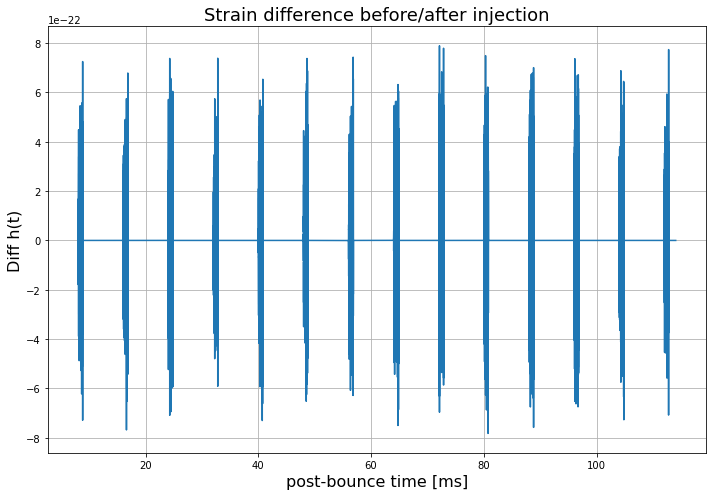

3614

<Figure size 432x288 with 0 Axes>

In [12]:
#%%script false --no-raise-error # WARNING: DEACTIVATED CELL

# ------> Check plot for strain before/after injection

# Select an injection
inj_point_1 = locate_inj[0]
inj_point_2 = locate_inj[-1]
#inj_point_2 = locate_inj[5]
min_index = inj_point_1-100
max_index = inj_point_2+len(strain_wf)+5000

# Subset of points
time_n_subset = time_n[min_index:max_index]
strain_n_subset = strain_n[min_index:max_index]
strain_n_new_subset = strain_n_new[min_index:max_index]

plt.figure(1, figsize=(10,7))
#plt.plot(time_n_subset,strain_n_subset, label='Before injection')
#plt.plot(time_n_subset,strain_n_new_subset, label='After injection')
plt.plot(time_n_subset,strain_n_subset-strain_n_new_subset, label='difference')
#plt.yscale('log')
plt.title("Strain difference before/after injection", fontsize=18)
plt.xlabel('post-bounce time [ms]', fontsize=16)
plt.ylabel('Diff h(t)', fontsize=16)
plt.grid()
#plt.legend()
plt.tight_layout()
plt.show()
plt.figure(1).clear()
gc.collect()

## 7. Save data

In [13]:
# ------> Log files, information of injections

# Pre-processed data folder
save_dir = '/home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Codes/Preprocessed_Data/'

# Create df_log dataframe
df_log = pd.DataFrame(log_data, columns=['Injection time [s]', 'jitter (seconds)', 'Waveform SNR', 'G-mode slope', 'Frequency f0 [Hz]', 'Frequency f1 [Hz]', 'Waveform duration [s]'])

# Export df_log dataframe to a csv file
df_log.to_csv(save_dir + "log_" + detector + "_" + F_noi[nfile_i][ind_ini_n:ind_end_n] + "_wfclass" + waveform_class +  '.dat', index=False)

# ------> Strain data with injections

# Create df_strain dataset
df_strain = pd.DataFrame({"time" : time_n, "strain" : strain_n_new})

# Export df_strain dataframe to a csv file
df_strain.to_csv(save_dir + "strain_" + detector + "_" + F_noi[nfile_i][ind_ini_n:ind_end_n] + "_injected_" + "wfclass" + waveform_class + ".txt", index=False)